## 1. Data preprocessing (lab 1)

### Fetch data

In [35]:
from ucimlrepo import fetch_ucirepo

heart_disease = fetch_ucirepo(id=45)

### Create a feature matrix

In [36]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

cat_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
num_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]

original_df = heart_disease.data.features

# Prepare categorical data
imputer = SimpleImputer(strategy="most_frequent")
original_df.loc[:, cat_features] = imputer.fit_transform(original_df[cat_features])

encoder = OneHotEncoder(categories="auto", sparse_output=False)
encoded_cat_data = encoder.fit_transform(original_df[cat_features])
encoded_features = encoder.get_feature_names_out(cat_features)
original_df[encoded_features] = pd.DataFrame(encoded_cat_data, columns=encoded_features)

# Prepare numerical data
scaler = MinMaxScaler()
scaled_num_data = scaler.fit_transform(original_df[num_features])
original_df[num_features] = pd.DataFrame(scaled_num_data, columns=num_features)

# Convert DataFrame to feature matrix
original_df = original_df.drop(columns=cat_features)
X = original_df.to_numpy()

### Create a target vector (convert values to {0,1} for binary classification)

In [37]:
import numpy as np

y = heart_disease.data.targets.to_numpy()
y_binary = np.where(y >= 1, 1, 0)

### Verify matrix/vector dimensions

In [38]:
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y_binary.shape}")

Feature matrix shape: (303, 28)
Target vector shape: (303, 1)


### Split dataset to test and train subsets

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [40]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (242, 28)
X_test shape: (61, 28)
y_train shape: (242, 1)
y_test shape: (61, 1)


## 2. Model

### Hiperparameters

In [41]:
ALPHA = 0.0001
EPOCH_LIMIT = 250
EPSILON = 0.0001
TRESHOLD = 0.5

### Functions

- $\sigma(x) = \frac{1}{1 + e^{-x}}$  
- $sigmoid(X=[x_{1}, x_{2}, ..., x_{n}]) = [\sigma(x_{1}), \sigma(x_{2}), ..., \sigma(x_{n})]$  

##### Let:  
$X_{i \times j}$=
$\begin{bmatrix}
    x_{11} & x_{12} & x_{13} & \dots  & x_{1j} \\
    x_{21} & x_{22} & x_{23} & \dots  & x_{2j} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_{i1} & x_{i2} & x_{i3} & \dots  & x_{ij}
\end{bmatrix}$, 
$W_{1 \times j}$=
$\begin{bmatrix}
    w_{1} & w_{2} & w_{3} & \dots  & w_{j}
\end{bmatrix}$,
$b_{1 \times 1}$=
$\begin{bmatrix}
    bias
\end{bmatrix}$,  

##### Then:
- $pred\_prob(X_{i \times j}, W_{1 \times j}, b_{1 \times 1}) = sigmoid(((XW^{T})_{i \times 1} + b\_ext_{i \times 1})_{i \times 1})$  
- $update\_weights(X_{i \times j}, W_{1 \times j}, p_{i \times 1}, y_{i \times 1}) = W_{1 \times j} + \alpha * (((y_{i \times 1} - p_{i \times 1})^{T})_{1 \times i}X_{i \times j})_{1 \times j}$

In [42]:
def sigmoid(vector: np.array) -> np.array:
    return 1 / (1 + np.exp(-vector))


def pred_prob(X: np.array, W: np.array, b: np.array) -> np.array:
    vector = (X @ W) + b
    return sigmoid(vector)


def update_weights(X: np.array, W: np.array, p: np.array, y: np.array) -> np.array:
    gradient = (y-p).T @ X
    return (W + (ALPHA * gradient).T)


def update_bias(b: np.array, p: np.array, y: np.array) -> np.array:
    gradient = np.sum(y - p)
    return b + (ALPHA * gradient)

### Model training

In [43]:
from sklearn.metrics import accuracy_score, f1_score, recall_score


def run(X_train: np.array, X_test: np.array, y_train: np.array,
        y_test: np.array, epoch_limit: int) -> dict[int, dict[str, np.float64]]:
    results = {}

    features_count = X_train.shape[1]
    W = np.zeros((features_count, 1))
    # W = (np.random.randn(features_count, 1) * 0.01)
    b = np.zeros((1,1))

    for i in range(epoch_limit):
        p = pred_prob(X_train, W, b)
        W_updated = update_weights(X_train, W, p, y_train)
        b = update_bias(b, p, y_train)
        test_p = pred_prob(X_test, W, b)
        test_p_binary = (test_p >= TRESHOLD).astype(int)
        results[i] = {
            "recall": recall_score(y_true=y_test, y_pred=test_p_binary),
            "f1": f1_score(y_true=y_test, y_pred=test_p_binary),
            "accuracy": accuracy_score(y_true=y_test, y_pred=test_p_binary)
        }
        if (np.abs(W_updated - W) <= EPSILON).all():
            return results
        W = W_updated
    return results

### Run the model and plot the metrics

In [44]:
import matplotlib.pyplot as plt


def plot_results(results: dict[int, np.float64]):
    x = list(results.keys())
    recall = [results[i]['recall'] for i in x]
    f1 = [results[i]['f1'] for i in x]
    accuracy = [results[i]['accuracy'] for i in x]

    plt.figure(figsize=(8, 6))
    plt.plot(x, recall, linestyle='-', color='r', label='Recall')
    plt.plot(x, f1, linestyle='-', color='g', label='F1 Score')
    plt.plot(x, accuracy, linestyle='-', color='b', label='Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Metric score')
    plt.title('Plot of metric scores')

    plt.xlim(0, 150)

    plt.legend()

    plt.grid(True)
    plt.show()

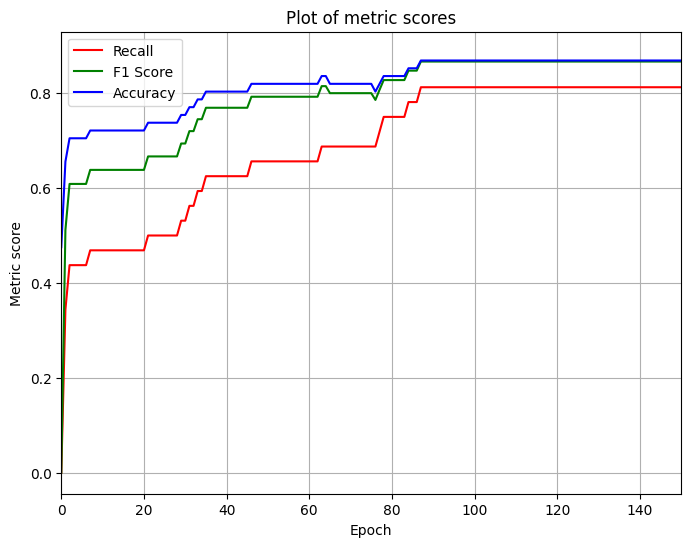

In [45]:
results = run(X_train, X_test, y_train, y_test, EPOCH_LIMIT)
plot_results(results)

## 3. Summary

**Observations:**
1. The above chart shows the performance metrics of a logistic regression model that was trained on medical data for the prediction of heart disease.

2. The model uses 28 features (preprocessed on the previous lab class) to predict a binary target - presence or absence of heart disease. Three metrics were used to visualise the performance of the model over time (time = epochs): Recall, F1 score, and Accuracy.

3. All three metrics started close to 0 but soon reached at least 0.5 after +/- 20 epochs. The overall trajectory implies that the performance of the model improves with more iterations (epochs).

4. Accuracy (blue line) shows the most stable performance, reaching about 0.85 by the end of training, while Recall (red line) "struggled" much more to improve its value, but finally finished with a value greater than 0.8.

5. All metrics seem to plateau after about 85 epochs, suggesting that further training is probably pointless.

**Conclusion**  
Based on the presented picture, we can conclude that this logistic regression model is quite effective in predicting heart disease from the given medical data. The recall metric is perhaps the most important as it describes the model's ability to identify positive cases. However, the overall accuracy is also high. We can assume that for such a simple task (binary classification) this type of model could be considered adequate.